In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[0] 
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


0
Wed Nov  8 15:08:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   31C    P0    39W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A 

In [2]:
import argparse
import json
import pickle
import string
import time

import numpy as np
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
from sklearn.cluster import KMeans, AgglomerativeClustering
import torch
from tqdm import tqdm

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--input-file", type=str, required=True)
parser.add_argument("--model", type=str, default="all-mpnet-base-v2")
# default="all-MiniLM-L12-v2")
# default="multi-qa-distilbert-cos-v1")
parser.add_argument("--batch-size", type=int, default=256)
parser.add_argument("--min-length", type=int)
parser.add_argument("--max-length", type=int)
parser.add_argument("--english-only", action="store_true")
parser.add_argument("--num-clusters", type=int, default=20)
parser.add_argument(
    "--cluster-alg",
    type=str,
    choices=["kmeans", "aggcls", "HDBSCAN"],
    default="kmeans",
)
parser.add_argument("--show-top-k", type=int, default=200)
parser.add_argument("--show-cut-off", type=int, default=512)


input_path = 'data/processed/sharegpt/sharegpt_data.jsonl'
input_path = 'data/processed/ultrachat/ultrachat_data.jsonl'

cmd = f"""
    --input-file {input_path}
    --min-length 32
    --max-length 1536
"""

args = jpt_parse_args(parser, cmd)


num_clusters = args.num_clusters
show_top_k = args.show_top_k
show_cut_off = args.show_cut_off

args

Namespace(input_file='data/processed/ultrachat/ultrachat_data.jsonl', model='all-mpnet-base-v2', batch_size=256, min_length=32, max_length=1536, english_only=False, num_clusters=20, cluster_alg='kmeans', show_top_k=200, show_cut_off=512)

In [29]:
from fastchat_topic_clustering import read_texts, remove_punctuation

## wpq: modify read_text a bit
# texts = read_texts(
#     args.input_file, args.min_length, args.max_length, args.english_only
# )
input_file = args.input_file
min_length = args.min_length
max_length = args.max_length

under_min_length = 0
above_max_length = 0

visited = set()
texts = []

with open(input_file, "r") as f:
    for l in f:
        l = json.loads(l)['messages']
        line_texts = [x['content'] for x in l if x['role']=='user']
        text_user = []
        for text in line_texts:
            text = text.strip()

            # Filter short or long prompts
            if min_length:
                if len(text) < min_length:
                    under_min_length += 1
                    continue
            if max_length:
                if len(text) > max_length:
                    above_max_length += 1
                    continue

            # De-duplication
            words = sorted([x.lower() for x in remove_punctuation(text).split(" ")])
            words = "".join(words)
            if words in visited:
                continue

            visited.add(words)
            text_user.append(text)
        texts.append(text_user)
        
print(f"#text: {len(texts)}")

#text: 219195


In [4]:
from datasets import load_dataset
from transformers import AutoTokenizer

input_file = args.input_file
tokenizer_name_or_path = 'sentence-transformers/'+args.model

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name_or_path)


ds = load_dataset('json', data_files={'train': input_file}, split='train',
                  cache_dir=os.path.dirname(input_file))

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/data/processed/ultrachat/json/default-4fd22f12db15a445/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


In [5]:
def compute_tok_len(example):
    input_ids = tokenizer([x['content'] for x in example['messages']]).input_ids
    example['tok_len'] = [len(x) for x in input_ids]
    return example
ds = ds.map(compute_tok_len, num_proc=32)

Map (num_proc=32):   0%|          | 0/219195 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1000 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (536 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [7]:
lens = ds['tok_len']

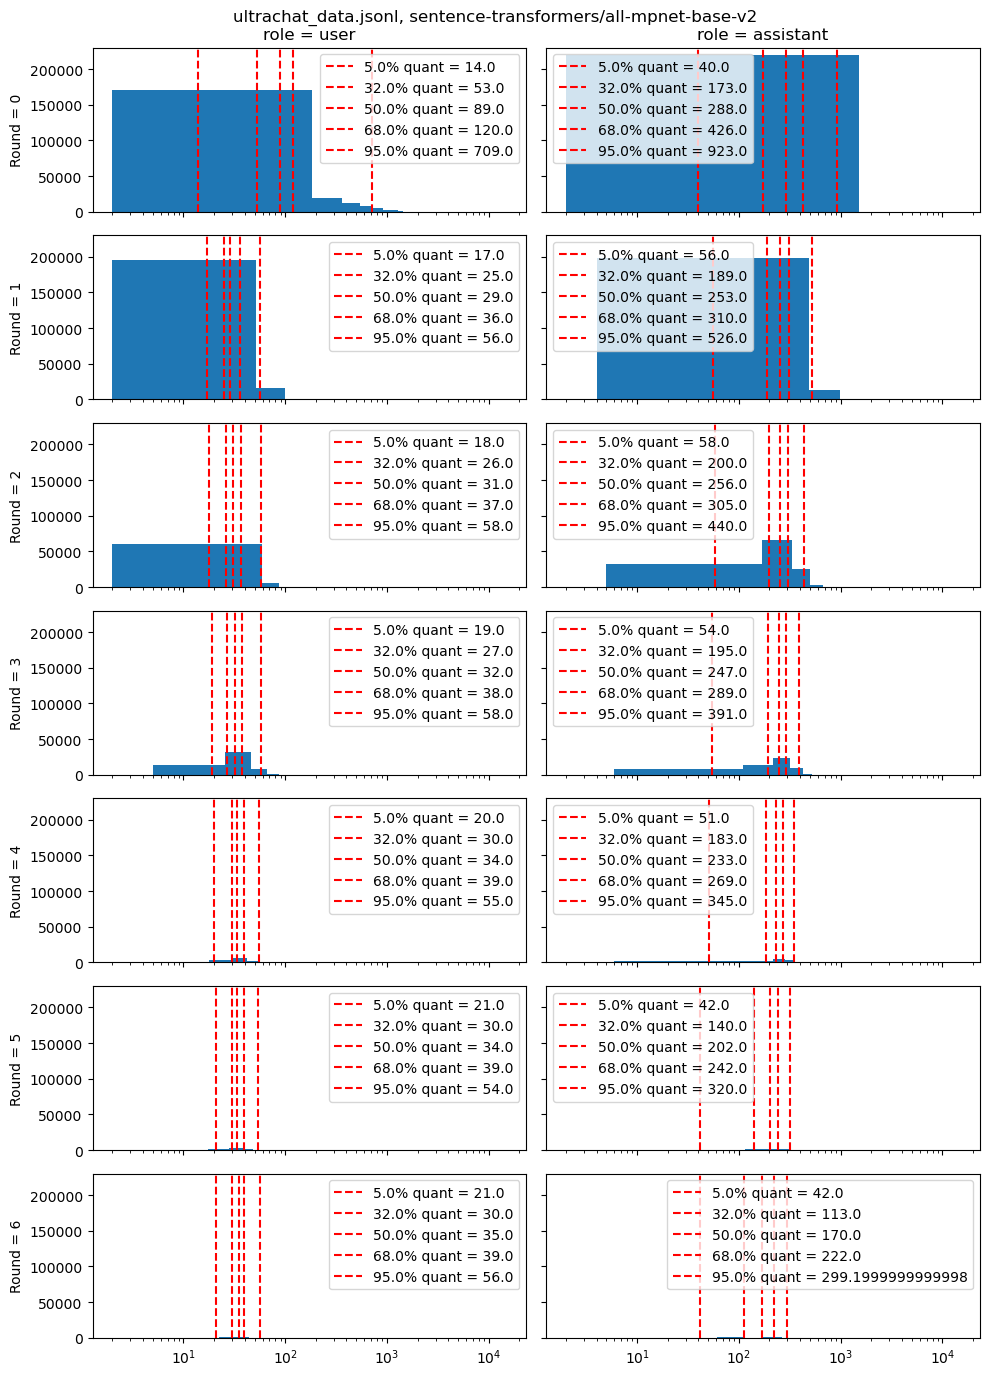

In [8]:
import matplotlib.pyplot as plt

max_turns = max([len(x)//2 for x in lens])
fig, axs = plt.subplots(max_turns, 2,figsize=(5*2, 2*max_turns), sharex=True, sharey=True)

for i, r in enumerate(range(max_turns)):
    for j, ind in enumerate([int(r*2), int(r*2)+1]):
        ax = axs[i, j]
        ys = [x[ind] for x in lens if len(x)>ind]
        ax.hist(ys)
        for q in [.05, .32, .5, .68, .95]:
            v = np.quantile(ys, q)
            ax.axvline(x=v, color='r', linestyle='--', label=f'{q*100}% quant = {v}')
        ax.legend()
        ax.set_xscale('log')
        if j == 0:
            ax.set_ylabel(f'Round = {r}')
        if i == 0:
            ax.set_title(f"role = {'user' if j==0 else 'assistant'}")
        
fig.suptitle(f'{os.path.basename(input_file)}, {tokenizer_name_or_path}')
fig.tight_layout()

In [13]:
from note_pruning_analysis import assets_dir

save_plt = 1
if save_plt:
    save_path = os.path.join(
        assets_dir, 
        f"note_pruning_{os.path.basename(input_file).split('.jsonl')[0]}_{':'.join(tokenizer_name_or_path.split('/'))}.png")
    fig.savefig(save_path, bbox_inches='tight', dpi=100)


In [11]:


def within_length_bounds_fn(example):
    t = example['messages'][0]['content']
    return (len(t) < args.min_length or len(t) > args.max_length)


dsf = ds.filter(within_length_bounds_fn, num_proc=16)




Filter (num_proc=16):   0%|          | 0/219195 [00:00<?, ? examples/s]

MPNetTokenizerFast(name_or_path='sentence-transformers/all-mpnet-base-v2', vocab_size=30527, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	104: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30526: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, norm

In [ ]:
# 
s = dsf[i]['messages'][0]['content']
' '.join(tokenizer.tokenize(s))


In [12]:
from note_pruning_analysis import convert_example_to_str

i = 12


t = dsf[i]['messages'][0]['content']
print(convert_example_to_str(0, dsf[i]))
print(len(t))
print(t)

metadata: {
    "dataset": "ultrachat",
    "id": "ultrachat_113",
    "idx": 0,
    "n_turns": 8
}

= USER        =
Here is a piece of text: DUBAI, Aug 26 (Reuters) - Saudi Arabia’s stock market outperformed by a large margin on Sunday, led by petrochemical stocks, as Middle Eastern bourses reopened after a one-week break for the Muslim festival of Eid Al Adha.
The Saudi stock index rose 1.4 percent, although trading volume was the lowest this year as some individual investors had not yet returned from holidays. Gainers outnumbered losers by 146 to 23.
The market has been buoyed this year by inflows of foreign funds in anticipation of Riyadh joining emerging market indexes next year. Recent exchange data indicates those inflows have slowed but not halted as stock valuations have risen.
Petrochemical makers were particularly strong after the Brent oil price rebounded above $75.0 a barrel last week. The top petrochemical firm, Saudi Basic Industries , added 1.8 percent and Saudi Kayan r

NameError: name 't' is not defined

In [30]:
print(under_min_length, above_max_length)

664 32991


In [28]:
# select the first instruction, gives the most information on the topic.

texts = [x[0] for x in texts]



['Please provide a specific cooking method for the salmon, as well as any seasonings or ingredients necessary to complete the dish. Additionally, include instructions for how to properly prepare the salmon before cooking, such as removing the skin or deboning. Please write in step-by-step format, using clear and concise language.',
 'Could you please suggest some side dishes that would pair well with the pan-seared salmon with lemon butter sauce recipe? also, do you have any recommendations for a wine pairing?',
 'Can you recommend some herb or spice blends that would pair nicely with the salmon dish? Also, do you have any recommendations for a dessert to finish off the meal?']

In [17]:
from fastchat_topic_clustering import get_embeddings


embeddings = get_embeddings(texts, args.model, args.batch_size)

[2023-11-08 00:02:46,673] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Batches:   4%|▍         | 53/1202 [01:36<34:53,  1.82s/it]

KeyboardInterrupt



Error in callback <bound method AutoreloadMagics.post_execute_hook of <IPython.extensions.autoreload.AutoreloadMagics object at 0x7f19c4a4e590>> (for post_execute):


KeyboardInterrupt: 

In [9]:
# max([len(x) for x in texts])


from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/'+args.model)
tokenizer


MPNetTokenizerFast(name_or_path='sentence-transformers/all-mpnet-base-v2', vocab_size=30527, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	104: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	30526: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, norm

In [10]:
input_ids = tokenizer(texts[:10000]).input_ids
lens = [len(x) for x in input_ids]
lens

[132,
 26,
 16,
 19,
 16,
 41,
 67,
 65,
 55,
 66,
 130,
 52,
 52,
 152,
 20,
 106,
 44,
 22,
 19,
 78,
 25,
 35,
 67,
 38,
 36,
 22,
 30,
 19,
 33,
 22,
 55,
 43,
 45,
 49,
 63,
 40,
 28,
 21,
 31,
 41,
 19,
 13,
 21,
 29,
 35,
 26,
 143,
 31,
 61,
 36,
 30,
 58,
 36,
 37,
 80,
 78,
 178,
 35,
 22,
 268,
 30,
 44,
 58,
 46,
 127,
 26,
 26,
 35,
 16,
 24,
 34,
 45,
 22,
 20,
 23,
 40,
 71,
 19,
 25,
 34,
 32,
 23,
 22,
 27,
 172,
 28,
 17,
 38,
 28,
 31,
 15,
 25,
 27,
 153,
 37,
 40,
 14,
 28,
 15,
 29,
 13,
 19,
 29,
 30,
 35,
 48,
 75,
 39,
 72,
 23,
 17,
 119,
 29,
 27,
 110,
 38,
 41,
 15,
 34,
 21,
 42,
 51,
 22,
 33,
 27,
 17,
 35,
 35,
 31,
 36,
 33,
 312,
 28,
 27,
 18,
 19,
 38,
 33,
 29,
 32,
 36,
 90,
 120,
 17,
 24,
 25,
 105,
 37,
 193,
 25,
 37,
 26,
 77,
 37,
 32,
 35,
 17,
 18,
 20,
 16,
 18,
 17,
 29,
 19,
 36,
 118,
 43,
 97,
 29,
 27,
 13,
 23,
 44,
 104,
 29,
 27,
 59,
 36,
 48,
 95,
 38,
 35,
 141,
 22,
 23,
 18,
 340,
 28,
 94,
 34,
 29,
 103,
 32,
 231,
 32,
 27

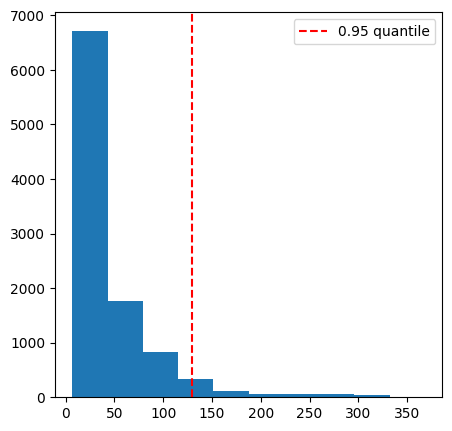

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.hist(lens)

q = .95
v = np.quantile(lens, q)
ax.axvline(x=v, color='r', linestyle='--', label=f'{q} quantile')
ax.legend()

In [16]:
from fastchat_topic_clustering import get_embeddings


embeddings = get_embeddings(texts, args.model, args.batch_size)
if args.cluster_alg == "kmeans":
    centers, labels = run_k_means(embeddings, num_clusters)
elif args.cluster_alg == "aggcls":
    centers, labels = run_agg_cluster(embeddings, num_clusters)
elif args.cluster_alg == "HDBSCAN":
    centers, labels = run_hdbscan_cluster(embeddings)
else:
    raise ValueError(f"Invalid clustering algorithm: {args.cluster_alg}")


307563